# PET deconvolution data setup notebook

In this notebook we'll simulate some 3D FDG brain PET acquisitions. \
1. Create FDG, uMap, T1 images of the brain as Numpy arrays - create SIRF `ImageData` objects using these
2. Create a `BlurringOperator` using CIL and an `AcquisitionModel` using SIRF. Use CIL's `CompositionOperator` to create a blurred forward model
3. Create simulated PET data using this blurred forward model
4. Using SIRF's `OSMAPOSLReconstructor` class, produce an OSEM-reoncstructed image that will be both blurred and noisy when compared to the ground truth image
5. Simulate a point source and use the blurred forward model to simulate the result of taking a point source measurement with our PET scanner

There isn't going to be a huge amount of explanation in this notebook as we assume that you will all be somewhat familiar with the Synergistic Image Reconstruction Framework [(SIRF)](https://github.com/SyneRBI/SIRF). We use some of the functionality of the Core Imaging Library [(CIL)](https://github.com/TomographicImaging/CIL) but this should be relatively self-explanatory and limited. We'll use this a little more in the next notebook and will provide some extra information then.

In [47]:
import os

import numpy as np
import matplotlib.pyplot as plt

import sirf.STIR as pet
from sirf.Utilities import examples_data_path
import brainweb

from cil.utilities.display import show2D # cil.utilities is a module that contains some functions to display images
from cil.optimisation.operators import  BlurringOperator, CompositionOperator # cil.optimisation operators to blur the image and to compose multiple operators

msg = pet.MessageRedirector() # suppress STIR messages

In [48]:
# Define parameters to ensure the same data is used for each run
noise_seed = 5
noise_level = 1
bw_seed = 1337

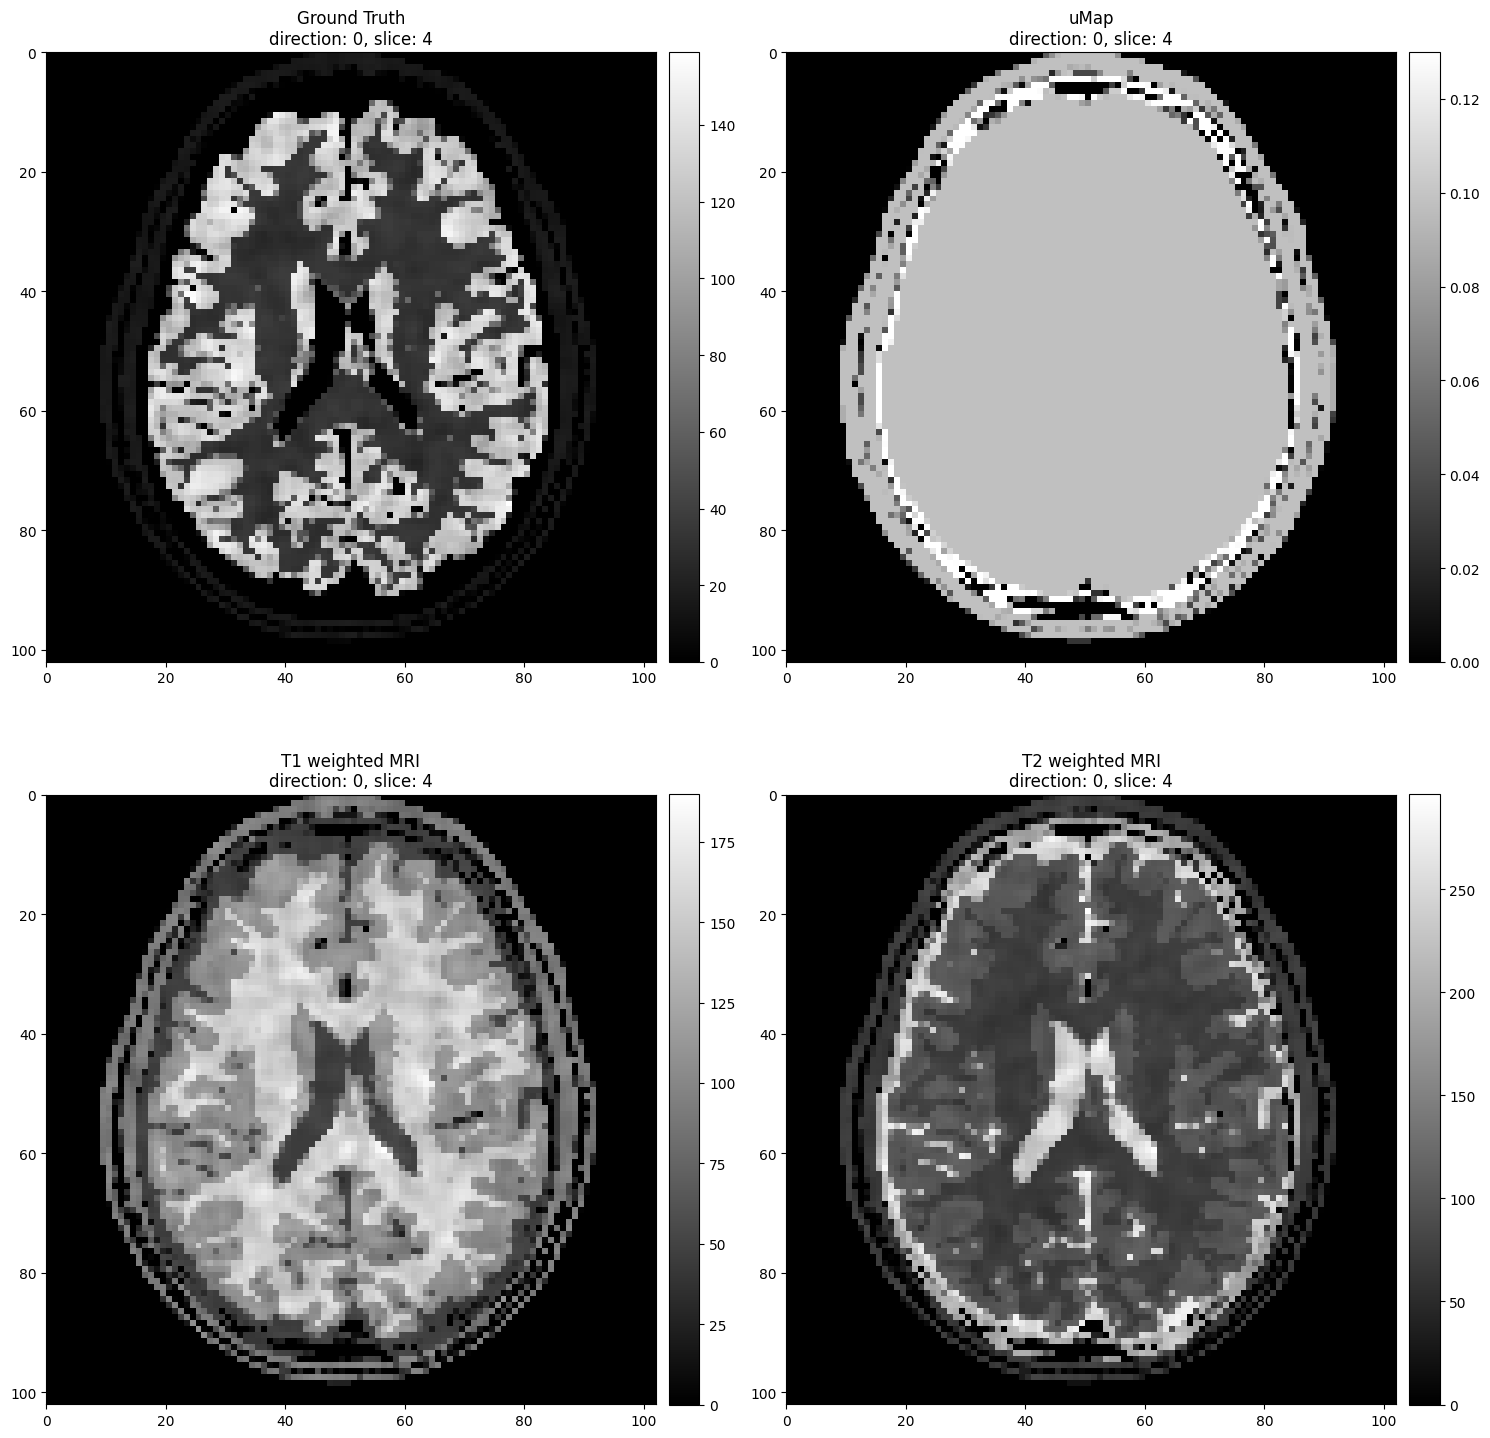

In [49]:
fname, url= sorted(brainweb.utils.LINKS.items())[0]
files = brainweb.get_file(fname, url, "data")
data = brainweb.load_file(os.path.join("data", fname))

brainweb.seed(bw_seed)

vol = brainweb.get_mmr_fromfile(os.path.join("data", fname),
        petNoise=1, t1Noise=0.75, t2Noise=0.75,
        petSigma=1, t1Sigma=1, t2Sigma=1)

# We'll extract the ground truth FDG PET, T1 MRI and T2 MRI images as well as the attenuation image (uMap)
arr_dict = {'PET': vol['PET'], 'T1': vol['T1'], 'T2': vol['T2'], 'uMap': vol['uMap']}

# desired shape of the images - note that changing these values requires updating the template sinogram header file (data/template_sinogram.hs)
crop_dim = (8,102,102)

def crop_array(arr, crop_dim):
    """
    Crop the array to the desired dimensions
    """
    y_start, x_start = (arr.shape[1] - crop_dim[1]) // 2, (arr.shape[2] - crop_dim[2]) // 2
    y_end, x_end = y_start + crop_dim[1], x_start + crop_dim[2]
    cropped_array = arr[:, y_start:y_end, x_start:x_end]

    # Step 2: Select slices in a stride-based manner to downsample to [15, 128, 128]
    num_slices = cropped_array.shape[0]
    stride = num_slices // crop_dim[0]

    # Ensure that we get exactly 15 slices
    selected_indices = np.linspace(0, num_slices - stride, crop_dim[0], dtype=int)
    downsampled_array = cropped_array[selected_indices, :, :]

    return downsampled_array

# Step 1: Crop the images to [15, 128, 128]
for key, image in arr_dict.items():
    arr_dict[key] = crop_array(image, crop_dim)

show2D([arr_dict['PET'], arr_dict['uMap'], arr_dict['T1'], arr_dict['T2']], title = ['Ground Truth', 'uMap', 'T1 weighted MRI', 'T2 weighted MRI'], origin = 'upper', num_cols = 2)

In [50]:
from sirf.STIR import *
from sirf.Utilities import examples_data_path

In [51]:
# Create a dictionary to store the SIRF ImageData objects and then initialise them
image_dict = {}
vsize = (6.75, 2.2, 2.2) # voxel sizes in mm
for key, image in arr_dict.items():
    image_dict[key] = pet.ImageData()
    image_dict[key].initialise(dim = crop_dim, vsize = vsize)
    image_dict[key].fill(image)
    image_dict[key].write(os.path.join('data',f'{key}_b{bw_seed}.hv'))

## Acquisition Model

Now let's set up our acquisition model. The acquisition process will both blur and add noise to the ground truth tracer distribution. Whilst there is functionality to do both of these in SIRF, we'll do the blurring using the CIL `BlurringOperator`.

In [52]:
# Now let's create a couple of functions to create a 3D Gaussian kernel

def fwhm_to_sigma(fwhm):
    return fwhm / (2 * np.sqrt(2 * np.log(2)))

def psf(n, fwhm, voxel_size=(1, 1, 1)):
    """ Creates a 3D point spread function (PSF) with specified sizes `n`, FWHM values `fwhm`, and voxel sizes `voxel_size` """

    sigma_voxels = [fwhm_to_sigma(fwhm[i]) / voxel_size[i] for i in range(3)]
    
    # Create Gaussian distributions for each dimension
    axes = [np.linspace(-(n - 1) / 2., (n - 1) / 2., n) for i in range(3)]
    gauss = [np.exp(-0.5 * np.square(ax) / np.square(sigma_voxels[i])) for i, ax in enumerate(axes)]

    # Create 3D Gaussian kernel
    kernel_3d = np.outer(gauss[0], gauss[1]).reshape(n, n, 1) * gauss[2].reshape(1, 1, n)
    
    # Normalize the kernel to ensure its sum equals one
    return kernel_3d / np.sum(kernel_3d)

In [53]:
# And then let's create a factory to create SIRF acquisition model object

def make_acquisition_model(template_sinogram, template_image, atten_image):

    # We'll start by initialising the acquisition model object
    acq_model = pet.AcquisitionModelUsingRayTracingMatrix()
    acq_model.set_num_tangential_LORs(10) 

    # In order to create LOR attenuation coefficients, we need to project the attenuation image into sinogram space
    acq_asm = pet.AcquisitionModelUsingRayTracingMatrix()
    acq_asm.set_num_tangential_LORs(10)
    acq_model.set_acquisition_sensitivity(pet.AcquisitionSensitivityModel(atten_image, acq_asm))

    # And finally, we can set up the acquisition model
    acq_model.set_up(template_sinogram,template_image)

    return acq_model

# and then add POISSON noise to simulated acquisition data

def add_poission_noise(acquistion_data, noise_level=10, seed=10):
    """
    Adds poisson noise to acquisition data
    """
    np.random.seed(seed)
    noisy_data = np.random.poisson(acquistion_data.as_array()/noise_level)*noise_level
    return acquistion_data.clone().fill(noisy_data)










Scanner parameters:= 
Scanner type := userdefined
Number of rings                          := 6
Number of detectors per ring             := 512
Inner ring diameter (cm)                 := 102
Average depth of interaction (cm)        := 0.7
Distance between rings (cm)              := 1.35
Default bin size (cm)                    := 0.3129
View offset (degrees)                    := 0
Maximum number of non-arc-corrected bins := 192
Default number of arc-corrected bins     := 192
Number of blocks per bucket in transaxial direction         := 1
Number of blocks per bucket in axial direction              := 1
Number of crystals per block in axial direction             := 1
Number of crystals per block in transaxial direction        := 8
Number of detector layers                                   := 1
Number of crystals per singles unit in axial direction      := 1
Number of crystals per singles unit in transaxial direction := 8
Scanner geometry (BlocksOnCylindrical/Cylindrical/Gene




Going ahead anyway.
no additive term added
applying unnormalisation...ok
no background term added
deleting tmp_16_1715164635096.hs failed, please delete manually
deleting tmp_16_1715164635096.s failed, please delete manually

Going ahead anyway.
no additive term added
applying unnormalisation...ok
no background term added
deleting tmp_17_1715164635280.hs failed, please delete manually
deleting tmp_17_1715164635280.s failed, please delete manually
deleting tmp_18_1715164635363.hs failed, please delete manually
deleting tmp_18_1715164635363.s failed, please delete manually


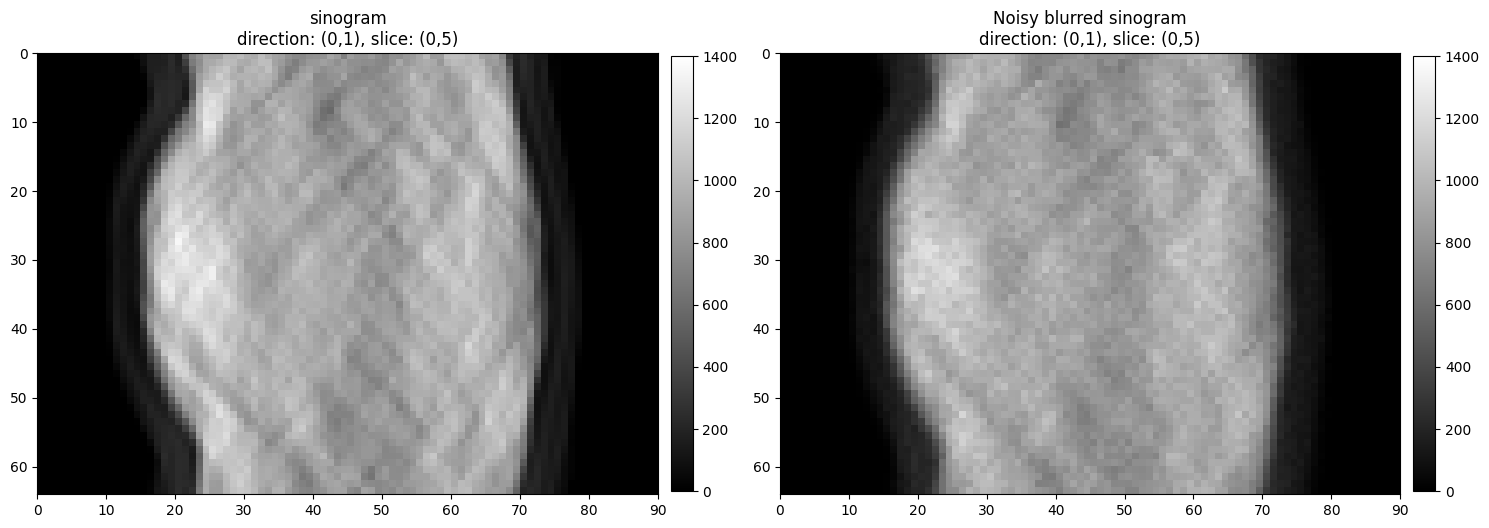

In [54]:
# Now we can create the acquisition model object
acq_model = make_acquisition_model(pet.AcquisitionData(os.path.join(examples_data_path('PET'), 'brain', 'template_sinogram.hs')), image_dict['PET'], image_dict['uMap'])

# We'll now create a noiseless sinogram for comparison
sinogram = acq_model.direct(image_dict['PET'])

# We'll create a 3D Gaussian kernel with a FWHM of 7 mm in each dimension
PSF=psf(15, fwhm=(7,7,7), voxel_size=vsize)

# And then we'll create a BlurringOperator to convolve the ground truth PET image with the PSF
convolve=BlurringOperator(PSF, image_dict['PET'])

# And now we'll model the forward operator including the point spread function
blurred_acq_model=CompositionOperator(acq_model, convolve)

# We'll now create a blurred sinogram and add Poisson noise
blurred_sinogram=blurred_acq_model.direct(image_dict['PET'])
blurred_noisy_sinogram=add_poission_noise(blurred_sinogram, noise_level=noise_level, seed=noise_seed)

sinogram.write(f'data/bw_sinogram_b{bw_seed}.hs')
blurred_noisy_sinogram.write(f'data/bw_blurred_noisy_sinogram_b_{bw_seed}_n{noise_seed}.hs')

show2D([sinogram, blurred_noisy_sinogram], title = ['sinogram', 'Noisy blurred sinogram'], origin = 'upper', num_cols = 2, fix_range=[(0,1400), (0,1400)])

Now for some reconstructions. The aim of this exercise is not to worry about the PSF during reconstruction and then try and correct for it later so we'll just use the SIRF acquisiton model in our reconstruction. 


Going ahead anyway.
Iteration: 11, Objective: -73148776.0


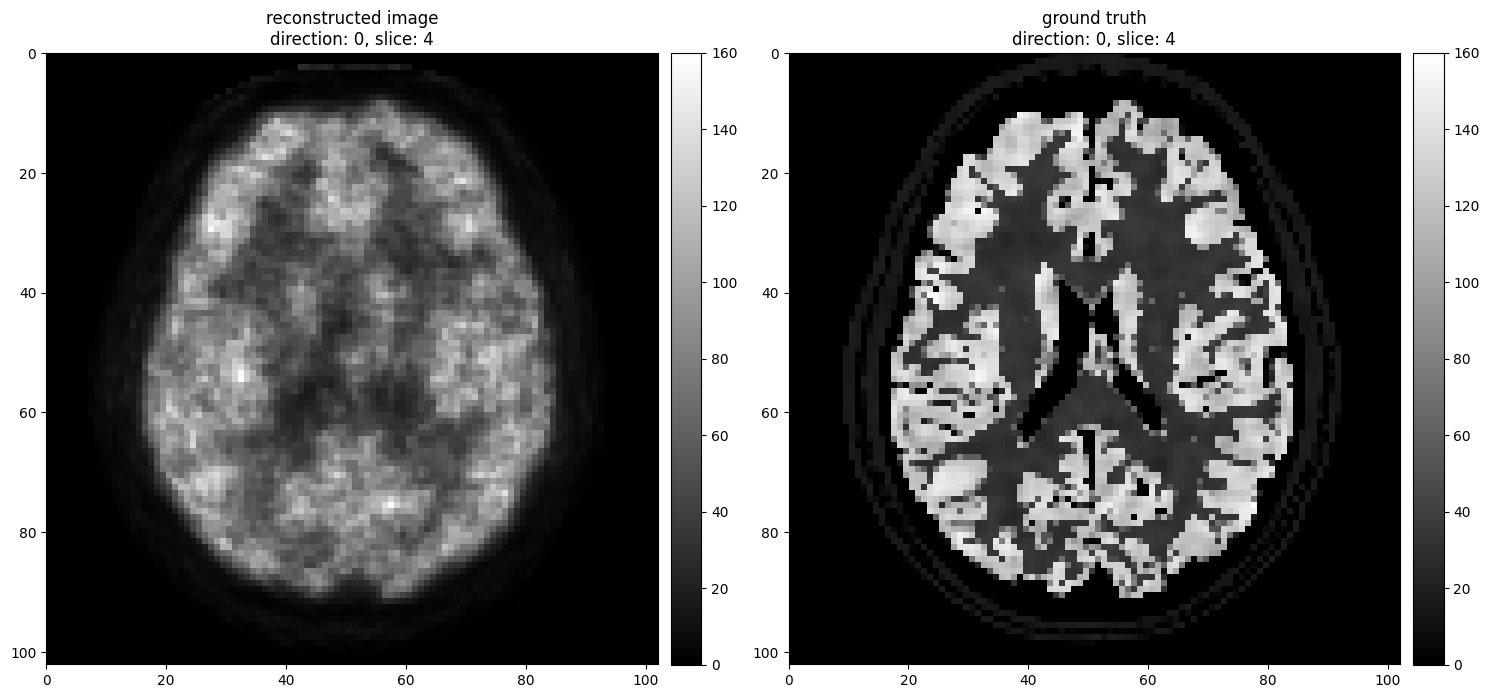

Text(0, 0.5, 'Objective Function Value')

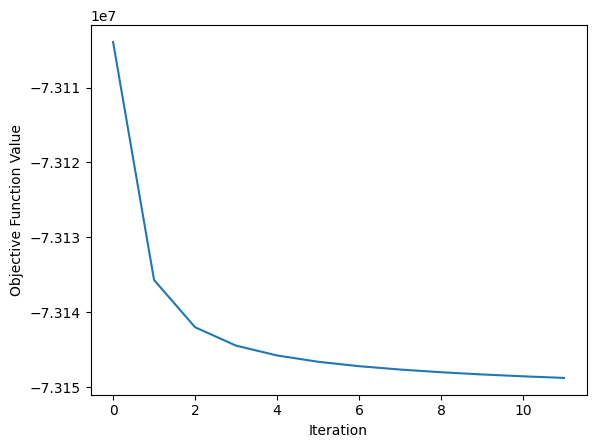

In [55]:
# Set up our objective function and reconstructor objects
objective_function = pet.make_Poisson_loglikelihood(blurred_noisy_sinogram, acq_model=acq_model) # PLL because we have Poisson noise
objective_function.set_num_subsets(8)
reconstructor = pet.OSMAPOSLReconstructor() # Ordered Subset Maximum A Posteriori One Step Late (OSMAPOSL) algorithm - we don't need to worry about the OSL part becuse we have no prior
reconstructor.set_num_subiterations(8)
reconstructor.set_objective_function(objective_function)
reconstructor.set_up(image_dict['PET'])

# create a processor to truncate the image to the cylinder
# This prevents edge effects from ruining the reconstruction
cyl = pet.TruncateToCylinderProcessor()
cyl.set_strictly_less_than_radius(True)

current_estimate = image_dict['PET'].get_uniform_copy(1) # initial estimate is a uniform image
cyl.apply(current_estimate) # truncated to a PET FOV
objective_list = []
full_iterations = 12 # number of full iterations to run

for i in range(full_iterations):
    reconstructor.reconstruct(current_estimate)
    objective_list.append(-objective_function(current_estimate))
    print(f"Iteration: {i}, Objective: {objective_list[-1]}", end = '\r')
    # remove any weird stuff from edge effects
    cyl.apply(current_estimate)

current_estimate.write(f'data/OSEM_b{bw_seed}_n{noise_seed}.hv')

show2D([current_estimate, image_dict['PET']], 
       title = ['reconstructed image', 'ground truth'], 
       origin = 'upper', num_cols = 2, fix_range=[(0,160), (0,160)])

plt.plot(objective_list)   
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

In order to make this a little more realistic, we'll simulate a point source mesurement, reconstructed with the same parameters as above. We can then use this reconstruction to estimate the PSF of our "scanner"


Going ahead anyway.
no additive term added
applying unnormalisation...ok
no background term added
deleting tmp_20_1715164642491.hs failed, please delete manually
deleting tmp_20_1715164642491.s failed, please delete manually

Going ahead anyway.
Iteration: 11, Objective: -9946.1376953125


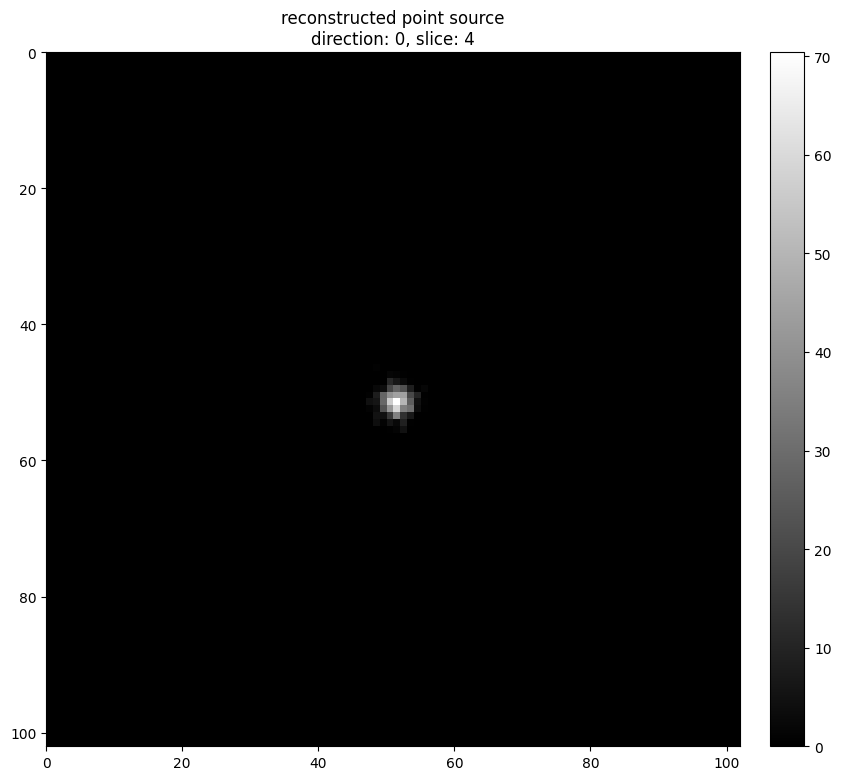

Text(0, 0.5, 'Objective Function Value')

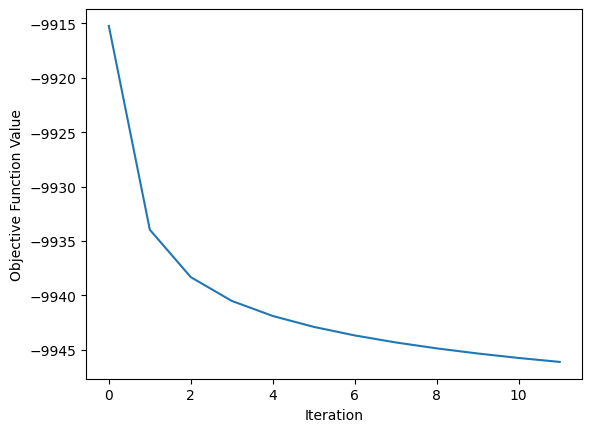

In [56]:
point_source = image_dict['PET'].get_uniform_copy(0)
point_source_arr = point_source.as_array()

point_source_arr[point_source_arr.shape[0]//2, point_source_arr.shape[1]//2, point_source_arr.shape[2]//2] = 1000
point_source.fill(point_source_arr)

point_source_sinogram = blurred_acq_model.direct(point_source)
point_source_sinogram = add_poission_noise(point_source_sinogram, noise_level=noise_level, seed=noise_seed)

objective_function = pet.make_Poisson_loglikelihood(point_source_sinogram, acq_model=acq_model)
objective_function.set_num_subsets(8)
reconstructor = pet.OSMAPOSLReconstructor()
reconstructor.set_num_subiterations(8)
reconstructor.set_objective_function(objective_function)
reconstructor.set_up(image_dict['PET'])

current_ps_estimate = image_dict['PET'].get_uniform_copy(1)
cyl.apply(current_ps_estimate)
objective_list = []
full_iterations = 12

for i in range(full_iterations):
    reconstructor.reconstruct(current_ps_estimate)
    objective_list.append(-objective_function(current_ps_estimate))
    print(f"Iteration: {i}, Objective: {objective_list[-1]}", end = '\r')
    # remove any weird stuff from edge effects
    cyl.apply(current_ps_estimate)

current_ps_estimate.write(os.path.join('data', f'OSEM_psf_n{noise_seed}.hv'))

show2D(reconstructor.get_current_estimate(), 
       title = 'reconstructed point source', 
       origin = 'upper', num_cols = 1)

plt.plot(objective_list)   
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')


In [57]:
# remove all files left over that should have been delted
# these start with tmp_ and end with .hs or .s
for file in os.listdir('.'):
    if file.startswith('tmp_') and (file.endswith('.hs') or file.endswith('.s')):
        os.remove(f'{file}')

## References

### Brainweb
C.A. Cocosco, V. Kollokian, R.K.-S. Kwan, A.C. Evans : "BrainWeb: Online Interface to a 3D MRI Simulated Brain Database"
NeuroImage, vol.5, no.4, part 2/4, S425, 1997 -- Proceedings of 3-rd International Conference on Functional Mapping of the Human Brain, Copenhagen, May 1997.
